# Lecture 4 - Demo Notebook 

## Prelimilaries: Imports and stuff

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.spatial.distance import pdist, cdist, squareform

# Data directory
DATA_DIR = "./../../data"

# Section 1: Pre-processing

## Read the data

In [3]:
# Parse the aggregated data frame
df_lq = pd.read_csv('{}/aggregated_extended_fc.csv'.format(DATA_DIR))
ts = pd.read_csv('{}/time_series_extended_fc.csv'.format(DATA_DIR))

## Clean the data

### We remove inactive students that did not click during weekdays and weekend for the fist 5 weeks of the semester.

In [4]:
def remove_inactive_students(df, ts):
    df = df.fillna('NaN')
    
    #find all users weeks with 0 clicks on weekends and 0 clicks on weekdays during the first weeks of the semester
    df_first = ts[ts.week < 5]
    rows = np.where(np.logical_and(df_first.ch_total_clicks_weekend==0, df_first.ch_total_clicks_weekday == 0).to_numpy())[0]
    df_zero = df_first.iloc[rows,:]
    dropusers = np.unique(df_zero.user)

    ts = ts[ts.user.isin(dropusers)==False]
    df = df[df.user.isin(dropusers)==False]
    return df, ts

df_lq, ts = remove_inactive_students(df_lq, ts)
# print(df_lq.columns)


In [5]:
display(df_lq)

,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,bo_delay_lecture,...,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play,grade,gender,category,year
1,1,3.4,1698.4,9227.8,0.567500,4.0,179.4,3068.720238,1257.504407,-2883.367738,...,0.748868,0.074683,0.0,0.066456,0.0,0.332424,4.50,M,Suisse.Autres,Y2-2018-19
2,2,5.3,2340.6,10801.3,26.562274,94.6,129.2,1750.289268,1024.134043,10027.216667,...,0.354487,0.026667,0.0,0.059915,0.0,0.284407,5.25,M,Suisse.PAM,Y2-2018-19
4,4,2.5,3787.3,7040.0,1.543889,58.4,64.9,3373.908333,1363.320365,-914.633333,...,0.030000,0.000000,0.0,0.020000,0.0,0.199775,4.75,F,France,Y2-2018-19
5,5,2.5,2568.9,3718.9,0.009677,31.2,50.8,1753.647500,1190.793589,12406.195238,...,0.330000,0.097619,0.0,0.047619,0.0,0.261962,4.00,M,Suisse.PAM,Y2-2018-19
6,6,4.2,5475.2,9711.6,0.476263,105.1,46.7,20410.677619,1561.548415,-13723.616667,...,0.080000,0.010000,0.0,0.000000,0.0,0.229185,4.25,F,France,Y2-2018-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,281,2.2,2600.3,3071.8,0.213467,20.6,122.6,2429.026667,336.303590,-69623.272700,...,0.616667,0.027894,0.0,0.015385,0.0,0.205969,5.75,M,Suisse.PAM,Y3-2019-20
276,285,1.8,2111.4,2130.4,0.236626,7.0,21.2,1378.954762,544.967013,23125.010000,...,0.352244,0.057692,0.0,0.047619,0.0,0.027091,4.00,F,France,Y3-2019-20
277,286,1.9,2224.8,2408.1,0.326239,20.5,46.7,1744.663333,664.335107,4812.464286,...,0.261205,0.014286,0.0,0.000000,0.0,0.137474,4.50,M,France,Y3-2019-20
281,291,4.0,6898.3,5657.2,0.080266,131.5,15.7,2323.840952,1623.425778,-5626.100000,...,0.033333,0.000000,0.0,0.000000,0.0,0.173431,5.50,M,France,Y3-2019-20


In [6]:
display(ts)

,week,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,...,la_seek_len_std,la_pause_dur_std,la_time_speeding_up_mean,la_time_speeding_up_std,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play
1,0,1,7.0,326.0,15525.0,5.675000,40.0,227.0,1931.285714,1648.472515,...,146.564097,188.175709,65.173554,150.807752,0.6,0.1,0.0,0.0,0.0,0.400749
2,0,2,4.0,1224.0,12209.0,258.000000,1.0,258.0,2780.250000,2297.110400,...,33.419147,39.702700,0.000000,0.000000,0.6,0.0,0.0,0.0,0.0,0.370656
4,0,4,4.0,1294.0,12037.0,0.328571,140.0,46.0,3043.750000,344.374342,...,159.612354,228.274335,67.941176,111.514074,0.3,0.0,0.0,0.2,0.0,0.252688
5,0,5,2.0,1324.0,4440.0,0.000000,119.0,0.0,2882.000000,2827.000000,...,99.684654,182.336877,51.760000,146.965446,0.0,0.0,0.0,0.0,0.0,0.411765
6,0,6,3.0,1773.0,14462.0,1.411765,102.0,144.0,5411.666667,2459.581039,...,116.878539,135.989183,0.000000,0.000000,0.6,0.1,0.0,0.0,0.0,0.353659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,9,281,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2868,9,285,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2869,9,286,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2873,9,291,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


## Prepare data for classification  

### Add a pass/fail label 

In [7]:
# We first add a column to the dataframe containing the outcome variable
# compute pass/fail label
df_lq['passed'] = df_lq.grade >= 4
df_lq['passed'] = df_lq['passed'].astype(int)

### Remove "bad" features and Split Data

In [8]:
# We then split the data in a train-test split (stratified by the outcome variable)
X = df_lq.drop(['user','grade', 'gender', 'category', 'year', 'passed'], axis=1)
y = df_lq['passed']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # split train and validation data set

### Print pass/fail proportions

In [9]:
# The class proportions in train and validation sets are the same, thanks to the stratification on y
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

1    0.604278
0    0.395722
Name: passed, dtype: float64
1    0.595745
0    0.404255
Name: passed, dtype: float64


## Define Evaluation Metrics (will see later in the slides)

In [10]:
def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum = 3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy =  balanced_accuracy_score(y_test, y_pred)
    
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return round(accuracy,roundnum), round(auc,roundnum)

# Section 2: Decision Trees

### Compute a decision tree of max depth 2  over all the features

In [11]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=0, criterion='entropy')
accuracy, auc = compute_scores(clf, X_train, y_train, X_val, y_val)
print("Decision tree. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Decision tree. Balanced Accuracy = 0.577, AUC = 0.602


### Visualize the decision tree

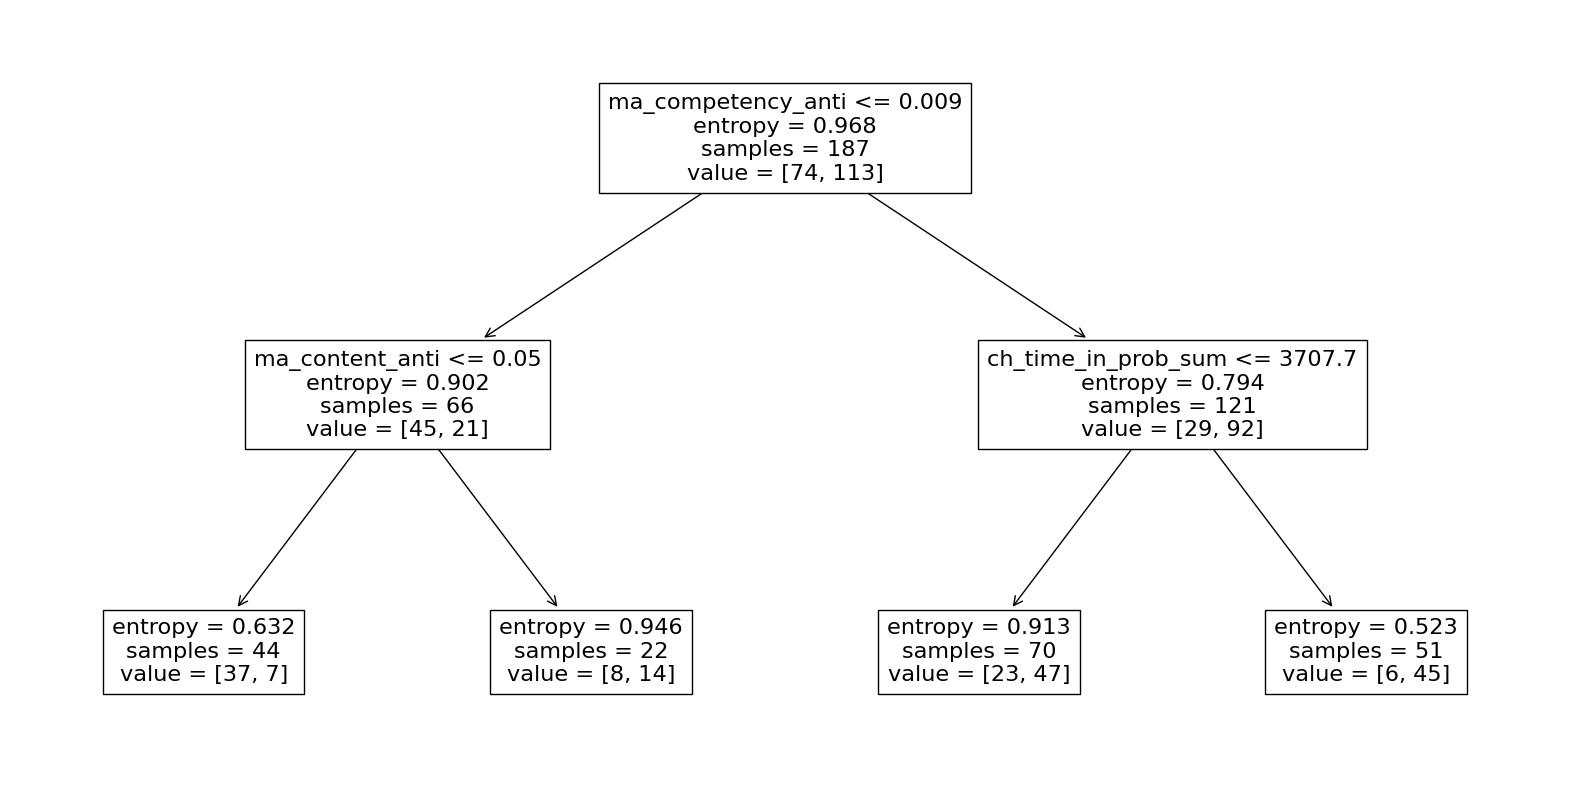

In [12]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X_train.columns);

### Does depth improves perfromance ?

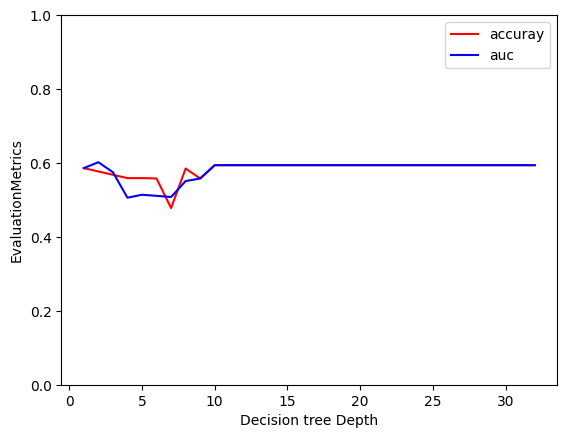

In [13]:
# We can change the max depth
accuracy_list = []
auc_list = []
for depth in range(1,len(X_train.columns)):
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=0, criterion='entropy')
    accuracy, auc = compute_scores(clf, X_train, y_train, X_val, y_val)
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    # print("Decision tree. Depth = {}, Balanced Accuracy = {}, AUC = {}".format(depth, accuracy, auc))
x = list(range(1,len(X_train.columns)))
plt.plot(x, accuracy_list, 'r', label = 'accuray')
plt.plot(x, auc_list, 'b', label = 'auc')
plt.xlabel("Decision tree Depth")
plt.ylabel("EvaluationMetrics")
plt.ylim([0,1])
plt.legend()
plt.show()

# Section 3: Random Forests

Next, we will use a random forest classifier instead of a decision tree.

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, criterion='entropy') # create a Random Forest
accuracy, auc = compute_scores(rf, X_train, y_train, X_val, y_val)
print("Random Forest. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Random Forest. Balanced Accuracy = 0.507, AUC = 0.603


For a single tree, in fact, keeping a low depth is necessary to avoid overfitting and to reduce the variance. Random forests, instead, can have a higher depth, and consequently a lower bias, since the variance is reduced in the aggregation step.

In this case, decision trees seem to perform better than random forests. A reason for this behavior could be that the single tree is already very "stable", i.e. it will change a little in response to little changes in the data. If this was the case, the submodels in the ensemble forest would be all very similar to the single tree, if they were allowed to choose among all the features at every split. Since, though, only a random subset of features is considered at each split, some subtrees would choose bad splits and have overall bad performances.

# Section 4: K-Nearest Neighbors

We only use the euclidean distance since all our features are numerical

In [15]:
feature = 'ch_time_in_prob_sum'

# Compute the pairwise distance matrix for all the elements of the training set
X_train_dist = squareform(pdist(X_train[feature].to_numpy().reshape(-1,1), metric='euclidean'))

# Compute the distance between all elements of the training set and of the validation set
X_val_dist = cdist(X_val[feature].to_numpy().reshape(-1,1), X_train[feature].to_numpy().reshape(-1,1), metric='euclidean')

X_train_dist

array([[   0. ,  181.9,  932.5, ..., 1821.3, 1884.6, 2220.8],
       [ 181.9,    0. ,  750.6, ..., 1639.4, 2066.5, 2402.7],
       [ 932.5,  750.6,    0. , ...,  888.8, 2817.1, 3153.3],
       ...,
       [1821.3, 1639.4,  888.8, ...,    0. , 3705.9, 4042.1],
       [1884.6, 2066.5, 2817.1, ..., 3705.9,    0. ,  336.2],
       [2220.8, 2402.7, 3153.3, ..., 4042.1,  336.2,    0. ]])

In [16]:
print('Training set size:', X_train.shape)
print('Validation set size:', X_val.shape)
print('Training pairwise distances size:', X_train_dist.shape)
print('Validation distances size:', X_val_dist.shape)

Training set size: (187, 33)
Validation set size: (47, 33)
Training pairwise distances size: (187, 187)
Validation distances size: (47, 187)


In [17]:
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

accuracy, auc = compute_scores(knn, X_train_dist, y_train, X_val_dist, y_val)
print("k-nearest neighbors. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

k-nearest neighbors. Balanced Accuracy = 0.533, AUC = 0.548


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Section 5: Logistic regression

We normalize the data data using the MinMaxScaler such that all the features are on the same scale.

In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled  = scaler.transform(X_val)

clf = LogisticRegression(random_state=0)
accuracy, auc = compute_scores(clf, X_train_scaled, y_train, X_val_scaled, y_val)
print("Logistic Regression. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Logistic Regression. Balanced Accuracy = 0.577, AUC = 0.626


# Section 6: Time Series - Your Turn

Build a classifier that can predict whether students pass the course after half of the course (5 weeks). You will need to use the data frame **ts** for this task. You can use kNN, RF, or decision tree. Train your model on the training data and predict on the test data.

We first drop all the weeks before week 5 and then perform the train/test split.

In [19]:
# Consider only data up to the 5th week
ts = ts[ts.week <= 5]

In [20]:
# Train-test split done on the users, so that all the rows corresponding to one user go into the same set.
users = ts.user.unique()
y = df_lq.passed
users_train, users_val, y_train, y_val = train_test_split(users, y, test_size=0.2, random_state=0, stratify=y)

X_train = ts[ts.user.isin(users_train)]
X_val = ts[ts.user.isin(users_val)]

In [21]:
# Sort indexes to make label arrays consistent with the data
y_train = y_train.sort_index()
y_val = y_val.sort_index()

### Decision tree/Random forest
For decision tree and RF, we need to aggregate the features to be able to feed them directly in the mode. We use the mean as an aggregation function.

In [22]:
# Aggregate features

groups_train = X_train.drop('week', axis = 1).groupby('user', as_index = False)
groups_val = X_val.drop('week', axis = 1).groupby('user', as_index = False)

standard_train = groups_train.std()
averages_train = groups_train.mean()
standard_val = groups_val.std()
averages_val = groups_val.mean()

X_train_aggregate = pd.concat([standard_train, averages_train], axis=1)
X_val_aggregate = pd.concat([standard_val, averages_val], axis=1)
X_train_aggregate.head()

,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,bo_delay_lecture,...,la_seek_len_std,la_pause_dur_std,la_time_speeding_up_mean,la_time_speeding_up_std,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play
0,2,3.391165,2109.754962,6234.491952,104.883843,82.771976,103.319730,656.590004,763.194436,100718.818602,...,48.407218,53.451086,0.000000,0.000000,0.535256,0.044444,0.0,0.062821,0.0,0.362171
1,5,1.095445,2254.745433,2119.963773,0.039508,57.595139,38.301001,1562.122278,1395.886413,42682.471658,...,67.829390,127.319742,41.157554,92.320811,0.216667,0.027778,0.0,0.000000,0.0,0.313901
2,6,1.505545,2872.580959,4712.799423,0.827940,70.164806,57.094366,1230.317804,748.645929,38052.014201,...,34.276359,80.200974,0.000000,0.000000,0.133333,0.016667,0.0,0.000000,0.0,0.290923
3,7,1.760682,2224.075868,3908.428094,0.267992,73.841497,78.863807,325.721484,1004.619798,70834.903484,...,116.938662,214.271981,0.000000,0.000000,0.242628,0.016667,0.0,0.050000,0.0,0.334971
4,8,1.366260,3821.751924,2660.061704,7.804323,110.199214,182.871540,1463.288505,1819.357850,33286.469085,...,107.620927,92.403015,5.651399,7.440532,0.202564,0.000000,0.0,0.000000,0.0,0.382115


In [23]:
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=2, 
                                  random_state=0, criterion='entropy')

accuracy, auc = compute_scores(clf, X_train_aggregate, y_train, X_val_aggregate, y_val)
print("Decision tree. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Decision tree. Balanced Accuracy = 0.49, AUC = 0.585


In [24]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, criterion='entropy') # create a Random Forest

accuracy, auc = compute_scores(rf,X_train_aggregate, y_train, X_val_aggregate, y_val)
print("Random Forest. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Random Forest. Balanced Accuracy = 0.603, AUC = 0.586


### K-Nearest Neighbors
For kNN, we don't need to aggregate the features. We directly compute the pairwise Euclidean distance between users, separately for each feature. We then normalize the pairwise distance matrices such that we can sum them up and feed them directly into the model.

In [25]:
feature = ['ch_time_in_prob_sum', 'ma_competency_anti','bo_delay_lecture']

X_train_vectors = X_train.groupby('user')[feature].agg(list)
X_val_vectors = X_val.groupby('user')[feature].agg(list)

X_train_vectors.head()

,ch_time_in_prob_sum,ma_competency_anti,bo_delay_lecture
user,,,
2,"[1224.0, 1310.0, 6185.0, 3195.0, 5545.0, 2515.0]","[0.0256410256410256, 0.08, 0.057471264367816, ...","[-8998.0, -22764.666666666668, 228700.0, -3375..."
5,"[1324.0, 266.0, 4700.0, 4014.0, 4881.0, 0.0]","[0.0341880341880341, 0.0, 0.0, 0.1095890410958...","[0.0, -67829.0, 67143.66666666667, 0.0, 0.0, 0.0]"
6,"[1773.0, 5152.0, 6475.0, 8562.0, 6753.0, 10076.0]","[0.094017094017094, 0.13, 0.1379310344827586, ...","[-90548.16666666669, -46688.0, 0.0, 0.0, 0.0, ..."
7,"[6410.0, 902.0, 5776.0, 4517.0, 1540.0, 3827.0]","[0.094017094017094, 0.13, 0.1034482758620689, ...","[-96044.5, -100976.5, 0.0, -187836.66666666663..."
8,"[1527.0, 4861.0, 5211.0, 8722.0, 4512.0, 12462.0]","[0.094017094017094, 0.13, 0.057471264367816, 0...","[-26506.33333333333, 67210.33333333333, 0.0, -..."


In [26]:
def normalize(distance_matrix):
    range_matrix = np.max(distance_matrix) - np.min(distance_matrix)
    normalized = (distance_matrix - np.min(distance_matrix)) / range_matrix
    return normalized

# Compute the pairwise distance matrix for all the elements of the training set, by computing
# the distances between the vectors, for each of the features selected, and summing up
# the resulting matrices
X_train_dist = sum(map(lambda x: normalize(squareform(pdist(x[1].tolist(), metric='euclidean'))),
                       X_train_vectors.iteritems()))


# Same thing but between all elements of the training set and of the validation set
X_val_dist = sum(map(lambda x: normalize(cdist(x[0][1].tolist(), x[1][1].tolist(), metric='euclidean')), 
                     zip(X_val_vectors.iteritems(), X_train_vectors.iteritems())))

X_train_dist

array([[0.        , 0.67793804, 0.75784452, ..., 0.93718996, 0.81832837,
        0.90029793],
       [0.67793804, 0.        , 0.79042918, ..., 0.62833068, 0.54315213,
        0.64883377],
       [0.75784452, 0.79042918, 0.        , ..., 0.97117781, 0.88951047,
        0.53489505],
       ...,
       [0.93718996, 0.62833068, 0.97117781, ..., 0.        , 0.32428509,
        0.72269912],
       [0.81832837, 0.54315213, 0.88951047, ..., 0.32428509, 0.        ,
        0.62794624],
       [0.90029793, 0.64883377, 0.53489505, ..., 0.72269912, 0.62794624,
        0.        ]])

In [27]:
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

accuracy, auc = compute_scores(knn, X_train_dist, y_train, X_val_dist, y_val)
print("k-nearest neighbors. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

k-nearest neighbors. Balanced Accuracy = 0.647, AUC = 0.629


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
